# Running TB HIV scenarios

Usage sample (with scenarios and plotting)


To use the hiv comorbidity features, you will need to add these 3 things to the simulation:
- `HIV disease` to the disease list: Configure it as requested. Also, please note that if no intervention is specified, the model will use a initial prevalence and art coverage as specified in the HIV disease.
- `TB_HIV connector` to the connector list: You will have the hability to update the values of each modifier as specified in the connector.
- `HivIntervention` to the intervention list: The same intervention can be used for managing the art coverage and the prevalence depending on the specified parameters.




In [6]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import sciris as sc
import tbsim as mtb
import starsim as ss

## Build TB-HIV Simulation



In [7]:

def build_tbhiv_sim(simpars=None, tbpars=None, hivinv_pars=None) -> ss.Sim:
    """Build a TB-HIV simulation with current disease and intervention models."""
    
    # Set up the simulation parameters:
    default_simpars = dict(
        unit='day', dt=7,
        start=ss.date('1980-01-01'), stop=ss.date('2035-12-31'),
        rand_seed=123,
    )
    if simpars: default_simpars.update(simpars)
    
    # People:
    n_agents = 1000
    extra_states = [ss.FloatArr('SES', default=ss.bernoulli(p=0.3))]
    people = ss.People(n_agents=n_agents, extra_states=extra_states)

    # Disease 1: TB:
    pars = dict(beta=ss.beta(0.01), init_prev=ss.bernoulli(p=0.25), rel_sus_latentslow=0.1)
    if tbpars:
        pars.update(tbpars)
    tb = mtb.TB(pars=pars)

    # Disease 2: HIV:
    hiv_pars = dict(init_prev=ss.bernoulli(p=0.10), init_onart=ss.bernoulli(p=0.50))
    hiv = mtb.HIV(pars=hiv_pars)

    # Network:
    network = ss.RandomNet(pars=dict(n_contacts=ss.poisson(lam=2), dur=0))

    # Connector: TB-HIV
    connector = mtb.TB_HIV_Connector()
    
    # Interventions: HivInterventions 
    interventions = []
    if hivinv_pars is not None:
        hiv.update_pars(hiv_pars)
        hivinv_pars = hivinv_pars or dict(
            mode='both', 
            prevalence=0.20, 
            percent_on_ART=0.20,
            minimum_age=15, 
            max_age=49,
            start=ss.date('2000-01-01'), stop=ss.date('2010-12-31'),
        )
        hiv_intervention = mtb.HivInterventions(pars=hivinv_pars)
        interventions = [hiv_intervention]

    # Create the simulation:
    sim = ss.Sim(
        people=people,
        diseases=[tb, hiv],
        interventions=interventions,
        networks=network,
        connectors=[connector],
        pars=default_simpars,
    )
    return sim

## Run HIV Intervention Scenarios
This function runs multiple intervention strategies, each with varying HIV prevalence, ART coverage, and target age ranges.

In [ ]:
def run_scenarios():
   
    """Run the scenarios and return the results."""
    scenarios = {
        'baseline': None,
        'early_low_delivery_both':      dict(mode= 'both', prevalence=0.10, percent_on_ART=0.10, 
                                        minimum_age=15, max_age=49,
                                        start=ss.date('1990-01-01'), stop=ss.date('2000-12-31')),
        
        'high_coverage_delivery_both':  dict(mode= 'both', prevalence=0.25, percent_on_ART=0.75, 
                                        minimum_age=10, max_age=60,
                                        start=ss.date('2010-01-01'), stop=ss.date('2025-12-31')), 
        
        'infection_early_delivery':     dict(mode= 'infection', prevalence=0.10, 
                                        minimum_age=15, max_age=49,
                                        start=ss.date('1990-01-01'), stop=ss.date('2000-12-31')),
        
        'infection_early_delivery':     dict(mode= 'infection', prevalence=0.25,  
                                        minimum_age=10, max_age=60,
                                        start=ss.date('2010-01-01'), stop=ss.date('2025-12-31')), 
        
        'early_art_delivery':           dict(mode= 'art',  percent_on_ART=0.10, 
                                        minimum_age=15, max_age=49,
                                        start=ss.date('1990-01-01'), stop=ss.date('2000-12-31')),
        
        'high_art_delivery':            dict(mode= 'art',  percent_on_ART=0.75, 
                                        minimum_age=10, max_age=60,
                                        start=ss.date('2010-01-01'), stop=ss.date('2025-12-31')), 
    }
    flat_results = {}
    for name, hivinv_pars in scenarios.items():
        print(f'Running scenario: {name}')
        sim = build_tbhiv_sim(hivinv_pars=hivinv_pars)
        sim.run()
        flat_results[name] = sim.results.flatten()
    return flat_results

## Plotting Results
We extract relevant metrics across scenarios and generate time series plots to visualize their trends. Metrics can be filtered by keywords or exclusions.

In [9]:
def plot_results(flat_results, keywords=None, exclude=['15']):
    metrics = sorted({k for flat in flat_results.values() for k in flat.keys() if (not keywords or any(kw in k for kw in keywords))}, reverse=True)
    metrics = [m for m in metrics if not any(excl in m for excl in exclude)]
    n_metrics = len(metrics)
    if n_metrics > 0:
        n_cols = 5
        n_rows = int(np.ceil(n_metrics / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*2))
        axs = axs.flatten()
    cmap = plt.cm.get_cmap('tab10', len(flat_results))
    for i, metric in enumerate(metrics):
        ax = axs[i]
        for j, (scenario, flat) in enumerate(flat_results.items()):
            if metric in flat:
                result = flat[metric]
                ax.plot(result.timevec, result.values, label=scenario, color=cmap(j))
        ax.set_title(metric)
        ax.set_ylabel('%' if max(result.values) < 1 else 'Value')
        ax.set_xlabel('Time')
        ax.grid(True)
        ax.legend(loc='upper right', fontsize=6 if len(flat_results) <= 5 else 5)
        ax.set_facecolor('#f0f0f0')
    plt.tight_layout()
    plt.savefig(f'{sc.thisdir()}/tbhiv_scenarios.png', dpi=300)
    plt.show()

## Plotting

Running scenario: baseline
Initializing sim with 1000 agents
  Running 1980.01.01 ( 0/2922) (0.00 s)  ———————————————————— 0%
  Running 1980.03.11 (10/2922) (0.02 s)  ———————————————————— 0%
  Running 1980.05.20 (20/2922) (0.03 s)  ———————————————————— 1%
  Running 1980.07.29 (30/2922) (0.04 s)  ———————————————————— 1%
  Running 1980.10.07 (40/2922) (0.06 s)  ———————————————————— 1%
  Running 1980.12.16 (50/2922) (0.08 s)  ———————————————————— 2%
  Running 1981.02.24 (60/2922) (0.09 s)  ———————————————————— 2%
  Running 1981.05.05 (70/2922) (0.11 s)  ———————————————————— 2%
  Running 1981.07.14 (80/2922) (0.12 s)  ———————————————————— 3%
  Running 1981.09.22 (90/2922) (0.13 s)  ———————————————————— 3%
  Running 1981.12.01 (100/2922) (0.15 s)  ———————————————————— 3%
  Running 1982.02.09 (110/2922) (0.16 s)  ———————————————————— 4%
  Running 1982.04.20 (120/2922) (0.18 s)  ———————————————————— 4%
  Running 1982.06.29 (130/2922) (0.19 s)  ———————————————————— 4%
  Running 1982.09.07 (140

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 1, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")


  Running 1998.10.13 (980/2922) (1.46 s)  ••••••—————————————— 34%
  Running 1998.12.22 (990/2922) (1.48 s)  ••••••—————————————— 34%
  Running 1999.03.02 (1000/2922) (1.49 s)  ••••••—————————————— 34%
  Running 1999.05.11 (1010/2922) (1.51 s)  ••••••—————————————— 35%
  Running 1999.07.20 (1020/2922) (1.52 s)  ••••••—————————————— 35%
  Running 1999.09.28 (1030/2922) (1.53 s)  •••••••————————————— 35%
  Running 1999.12.07 (1040/2922) (1.55 s)  •••••••————————————— 36%
  Running 2000.02.15 (1050/2922) (1.56 s)  •••••••————————————— 36%
  Running 2000.04.25 (1060/2922) (1.58 s)  •••••••————————————— 36%
  Running 2000.07.04 (1070/2922) (1.59 s)  •••••••————————————— 37%
  Running 2000.09.12 (1080/2922) (1.61 s)  •••••••————————————— 37%
  Running 2000.11.21 (1090/2922) (1.62 s)  •••••••————————————— 37%
  Running 2001.01.30 (1100/2922) (1.64 s)  •••••••————————————— 38%
  Running 2001.04.10 (1110/2922) (1.65 s)  •••••••————————————— 38%
  Running 2001.06.19 (1120/2922) (1.66 s)  •••••••

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 1, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")


  Running 2024.04.09 (2310/2922) (3.34 s)  •••••••••••••••————— 79%
  Running 2024.06.18 (2320/2922) (3.35 s)  •••••••••••••••————— 79%
  Running 2024.08.27 (2330/2922) (3.36 s)  •••••••••••••••————— 80%
  Running 2024.11.05 (2340/2922) (3.38 s)  ••••••••••••••••———— 80%
  Running 2025.01.14 (2350/2922) (3.39 s)  ••••••••••••••••———— 80%
  Running 2025.03.25 (2360/2922) (3.41 s)  ••••••••••••••••———— 81%
  Running 2025.06.03 (2370/2922) (3.42 s)  ••••••••••••••••———— 81%
  Running 2025.08.12 (2380/2922) (3.44 s)  ••••••••••••••••———— 81%
  Running 2025.10.21 (2390/2922) (3.45 s)  ••••••••••••••••———— 82%
  Running 2025.12.30 (2400/2922) (3.46 s)  ••••••••••••••••———— 82%
  Running 2026.03.10 (2410/2922) (3.48 s)  ••••••••••••••••———— 83%
  Running 2026.05.19 (2420/2922) (3.49 s)  ••••••••••••••••———— 83%
  Running 2026.07.28 (2430/2922) (3.51 s)  ••••••••••••••••———— 83%
  Running 2026.10.06 (2440/2922) (3.52 s)  ••••••••••••••••———— 84%
  Running 2026.12.15 (2450/2922) (3.53 s)  •••••

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 1, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 2, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")


  Running 2014.02.11 (1780/2922) (2.58 s)  ••••••••••••———————— 61%
  Running 2014.04.22 (1790/2922) (2.60 s)  ••••••••••••———————— 61%
  Running 2014.07.01 (1800/2922) (2.61 s)  ••••••••••••———————— 62%
  Running 2014.09.09 (1810/2922) (2.63 s)  ••••••••••••———————— 62%
  Running 2014.11.18 (1820/2922) (2.64 s)  ••••••••••••———————— 62%
  Running 2015.01.27 (1830/2922) (2.66 s)  ••••••••••••———————— 63%
  Running 2015.04.07 (1840/2922) (2.67 s)  ••••••••••••———————— 63%
  Running 2015.06.16 (1850/2922) (2.69 s)  ••••••••••••———————— 63%
  Running 2015.08.25 (1860/2922) (2.70 s)  ••••••••••••———————— 64%
  Running 2015.11.03 (1870/2922) (2.71 s)  ••••••••••••———————— 64%
  Running 2016.01.12 (1880/2922) (2.73 s)  ••••••••••••———————— 64%
  Running 2016.03.22 (1890/2922) (2.74 s)  ••••••••••••———————— 65%
  Running 2016.05.31 (1900/2922) (2.76 s)  •••••••••••••——————— 65%
  Running 2016.08.09 (1910/2922) (2.77 s)  •••••••••••••——————— 65%
  Running 2016.10.18 (1920/2922) (2.79 s)  •••••

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 19, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")


  Running 1990.09.25 (560/2922) (0.83 s)  •••————————————————— 19%
  Running 1990.12.04 (570/2922) (0.85 s)  •••————————————————— 20%
  Running 1991.02.12 (580/2922) (0.87 s)  •••————————————————— 20%
  Running 1991.04.23 (590/2922) (0.88 s)  ••••———————————————— 20%
  Running 1991.07.02 (600/2922) (0.90 s)  ••••———————————————— 21%
  Running 1991.09.10 (610/2922) (0.91 s)  ••••———————————————— 21%
  Running 1991.11.19 (620/2922) (0.93 s)  ••••———————————————— 21%
  Running 1992.01.28 (630/2922) (0.94 s)  ••••———————————————— 22%
  Running 1992.04.07 (640/2922) (0.96 s)  ••••———————————————— 22%
  Running 1992.06.16 (650/2922) (0.97 s)  ••••———————————————— 22%
  Running 1992.08.25 (660/2922) (0.99 s)  ••••———————————————— 23%
  Running 1992.11.03 (670/2922) (1.00 s)  ••••———————————————— 23%
  Running 1993.01.12 (680/2922) (1.02 s)  ••••———————————————— 23%
  Running 1993.03.23 (690/2922) (1.03 s)  ••••———————————————— 24%


/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 18, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")


  Running 1993.06.01 (700/2922) (1.05 s)  ••••———————————————— 24%
  Running 1993.08.10 (710/2922) (1.06 s)  ••••———————————————— 24%
  Running 1993.10.19 (720/2922) (1.08 s)  ••••———————————————— 25%
  Running 1993.12.28 (730/2922) (1.09 s)  •••••——————————————— 25%
  Running 1994.03.08 (740/2922) (1.11 s)  •••••——————————————— 25%
  Running 1994.05.17 (750/2922) (1.12 s)  •••••——————————————— 26%
  Running 1994.07.26 (760/2922) (1.14 s)  •••••——————————————— 26%
  Running 1994.10.04 (770/2922) (1.15 s)  •••••——————————————— 26%
  Running 1994.12.13 (780/2922) (1.16 s)  •••••——————————————— 27%
  Running 1995.02.21 (790/2922) (1.18 s)  •••••——————————————— 27%
  Running 1995.05.02 (800/2922) (1.19 s)  •••••——————————————— 27%
  Running 1995.07.11 (810/2922) (1.21 s)  •••••——————————————— 28%
  Running 1995.09.19 (820/2922) (1.22 s)  •••••——————————————— 28%
  Running 1995.11.28 (830/2922) (1.24 s)  •••••——————————————— 28%
  Running 1996.02.06 (840/2922) (1.25 s)  •••••———————————————

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 124, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 123, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 122, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 121, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbiditie

  Running 2011.08.16 (1650/2922) (2.52 s)  •••••••••••————————— 57%
  Running 2011.10.25 (1660/2922) (2.53 s)  •••••••••••————————— 57%
  Running 2012.01.03 (1670/2922) (2.54 s)  •••••••••••————————— 57%
  Running 2012.03.13 (1680/2922) (2.56 s)  •••••••••••————————— 58%
  Running 2012.05.22 (1690/2922) (2.57 s)  •••••••••••————————— 58%
  Running 2012.07.31 (1700/2922) (2.59 s)  •••••••••••————————— 58%
  Running 2012.10.09 (1710/2922) (2.60 s)  •••••••••••————————— 59%
  Running 2012.12.18 (1720/2922) (2.62 s)  •••••••••••————————— 59%
  Running 2013.02.26 (1730/2922) (2.63 s)  •••••••••••————————— 59%
  Running 2013.05.07 (1740/2922) (2.64 s)  •••••••••••————————— 60%
  Running 2013.07.16 (1750/2922) (2.66 s)  •••••••••••————————— 60%
  Running 2013.09.24 (1760/2922) (2.67 s)  ••••••••••••———————— 60%
  Running 2013.12.03 (1770/2922) (2.69 s)  ••••••••••••———————— 61%
  Running 2014.02.11 (1780/2922) (2.70 s)  ••••••••••••———————— 61%
  Running 2014.04.22 (1790/2922) (2.71 s)  •••••

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 119, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 118, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 117, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 116, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")


  Running 2014.07.01 (1800/2922) (2.73 s)  ••••••••••••———————— 62%
  Running 2014.09.09 (1810/2922) (2.74 s)  ••••••••••••———————— 62%
  Running 2014.11.18 (1820/2922) (2.76 s)  ••••••••••••———————— 62%
  Running 2015.01.27 (1830/2922) (2.77 s)  ••••••••••••———————— 63%
  Running 2015.04.07 (1840/2922) (2.79 s)  ••••••••••••———————— 63%
  Running 2015.06.16 (1850/2922) (2.80 s)  ••••••••••••———————— 63%
  Running 2015.08.25 (1860/2922) (2.81 s)  ••••••••••••———————— 64%
  Running 2015.11.03 (1870/2922) (2.83 s)  ••••••••••••———————— 64%
  Running 2016.01.12 (1880/2922) (2.84 s)  ••••••••••••———————— 64%
  Running 2016.03.22 (1890/2922) (2.85 s)  ••••••••••••———————— 65%
  Running 2016.05.31 (1900/2922) (2.87 s)  •••••••••••••——————— 65%
  Running 2016.08.09 (1910/2922) (2.88 s)  •••••••••••••——————— 65%
  Running 2016.10.18 (1920/2922) (2.90 s)  •••••••••••••——————— 66%
  Running 2016.12.27 (1930/2922) (2.91 s)  •••••••••••••——————— 66%
  Running 2017.03.07 (1940/2922) (2.92 s)  •••••

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 115, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 114, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 113, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")


  Running 2020.03.31 (2100/2922) (3.14 s)  ••••••••••••••—————— 72%
  Running 2020.06.09 (2110/2922) (3.16 s)  ••••••••••••••—————— 72%
  Running 2020.08.18 (2120/2922) (3.17 s)  ••••••••••••••—————— 73%
  Running 2020.10.27 (2130/2922) (3.18 s)  ••••••••••••••—————— 73%
  Running 2021.01.05 (2140/2922) (3.20 s)  ••••••••••••••—————— 73%
  Running 2021.03.16 (2150/2922) (3.21 s)  ••••••••••••••—————— 74%
  Running 2021.05.25 (2160/2922) (3.23 s)  ••••••••••••••—————— 74%
  Running 2021.08.03 (2170/2922) (3.24 s)  ••••••••••••••—————— 74%
  Running 2021.10.12 (2180/2922) (3.26 s)  ••••••••••••••—————— 75%
  Running 2021.12.21 (2190/2922) (3.27 s)  ••••••••••••••—————— 75%
  Running 2022.03.01 (2200/2922) (3.29 s)  •••••••••••••••————— 75%
  Running 2022.05.10 (2210/2922) (3.30 s)  •••••••••••••••————— 76%
  Running 2022.07.19 (2220/2922) (3.31 s)  •••••••••••••••————— 76%
  Running 2022.09.27 (2230/2922) (3.33 s)  •••••••••••••••————— 76%
  Running 2022.12.06 (2240/2922) (3.34 s)  •••••

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 112, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 111, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")


  Running 2023.02.14 (2250/2922) (3.35 s)  •••••••••••••••————— 77%
  Running 2023.04.25 (2260/2922) (3.37 s)  •••••••••••••••————— 77%
  Running 2023.07.04 (2270/2922) (3.38 s)  •••••••••••••••————— 78%
  Running 2023.09.12 (2280/2922) (3.40 s)  •••••••••••••••————— 78%
  Running 2023.11.21 (2290/2922) (3.41 s)  •••••••••••••••————— 78%
  Running 2024.01.30 (2300/2922) (3.43 s)  •••••••••••••••————— 79%
  Running 2024.04.09 (2310/2922) (3.44 s)  •••••••••••••••————— 79%
  Running 2024.06.18 (2320/2922) (3.45 s)  •••••••••••••••————— 79%
  Running 2024.08.27 (2330/2922) (3.47 s)  •••••••••••••••————— 80%
  Running 2024.11.05 (2340/2922) (3.48 s)  ••••••••••••••••———— 80%
  Running 2025.01.14 (2350/2922) (3.49 s)  ••••••••••••••••———— 80%
  Running 2025.03.25 (2360/2922) (3.51 s)  ••••••••••••••••———— 81%
  Running 2025.06.03 (2370/2922) (3.52 s)  ••••••••••••••••———— 81%
  Running 2025.08.12 (2380/2922) (3.54 s)  ••••••••••••••••———— 81%
  Running 2025.10.21 (2390/2922) (3.55 s)  •••••

/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 110, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")


  Running 2025.12.30 (2400/2922) (3.56 s)  ••••••••••••••••———— 82%
  Running 2026.03.10 (2410/2922) (3.58 s)  ••••••••••••••••———— 83%
  Running 2026.05.19 (2420/2922) (3.59 s)  ••••••••••••••••———— 83%
  Running 2026.07.28 (2430/2922) (3.61 s)  ••••••••••••••••———— 83%
  Running 2026.10.06 (2440/2922) (3.62 s)  ••••••••••••••••———— 84%
  Running 2026.12.15 (2450/2922) (3.63 s)  ••••••••••••••••———— 84%
  Running 2027.02.23 (2460/2922) (3.64 s)  ••••••••••••••••———— 84%
  Running 2027.05.04 (2470/2922) (3.66 s)  ••••••••••••••••———— 85%
  Running 2027.07.13 (2480/2922) (3.67 s)  ••••••••••••••••———— 85%
  Running 2027.09.21 (2490/2922) (3.68 s)  •••••••••••••••••——— 85%
  Running 2027.11.30 (2500/2922) (3.70 s)  •••••••••••••••••——— 86%
  Running 2028.02.08 (2510/2922) (3.71 s)  •••••••••••••••••——— 86%
  Running 2028.04.18 (2520/2922) (3.72 s)  •••••••••••••••••——— 86%
  Running 2028.06.27 (2530/2922) (3.74 s)  •••••••••••••••••——— 87%
  Running 2028.09.05 (2540/2922) (3.75 s)  •••••

/var/folders/dr/x377cvd10rl0xw0c1tj1vvzh0000gn/T/ipykernel_79305/1139370148.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(flat_results))


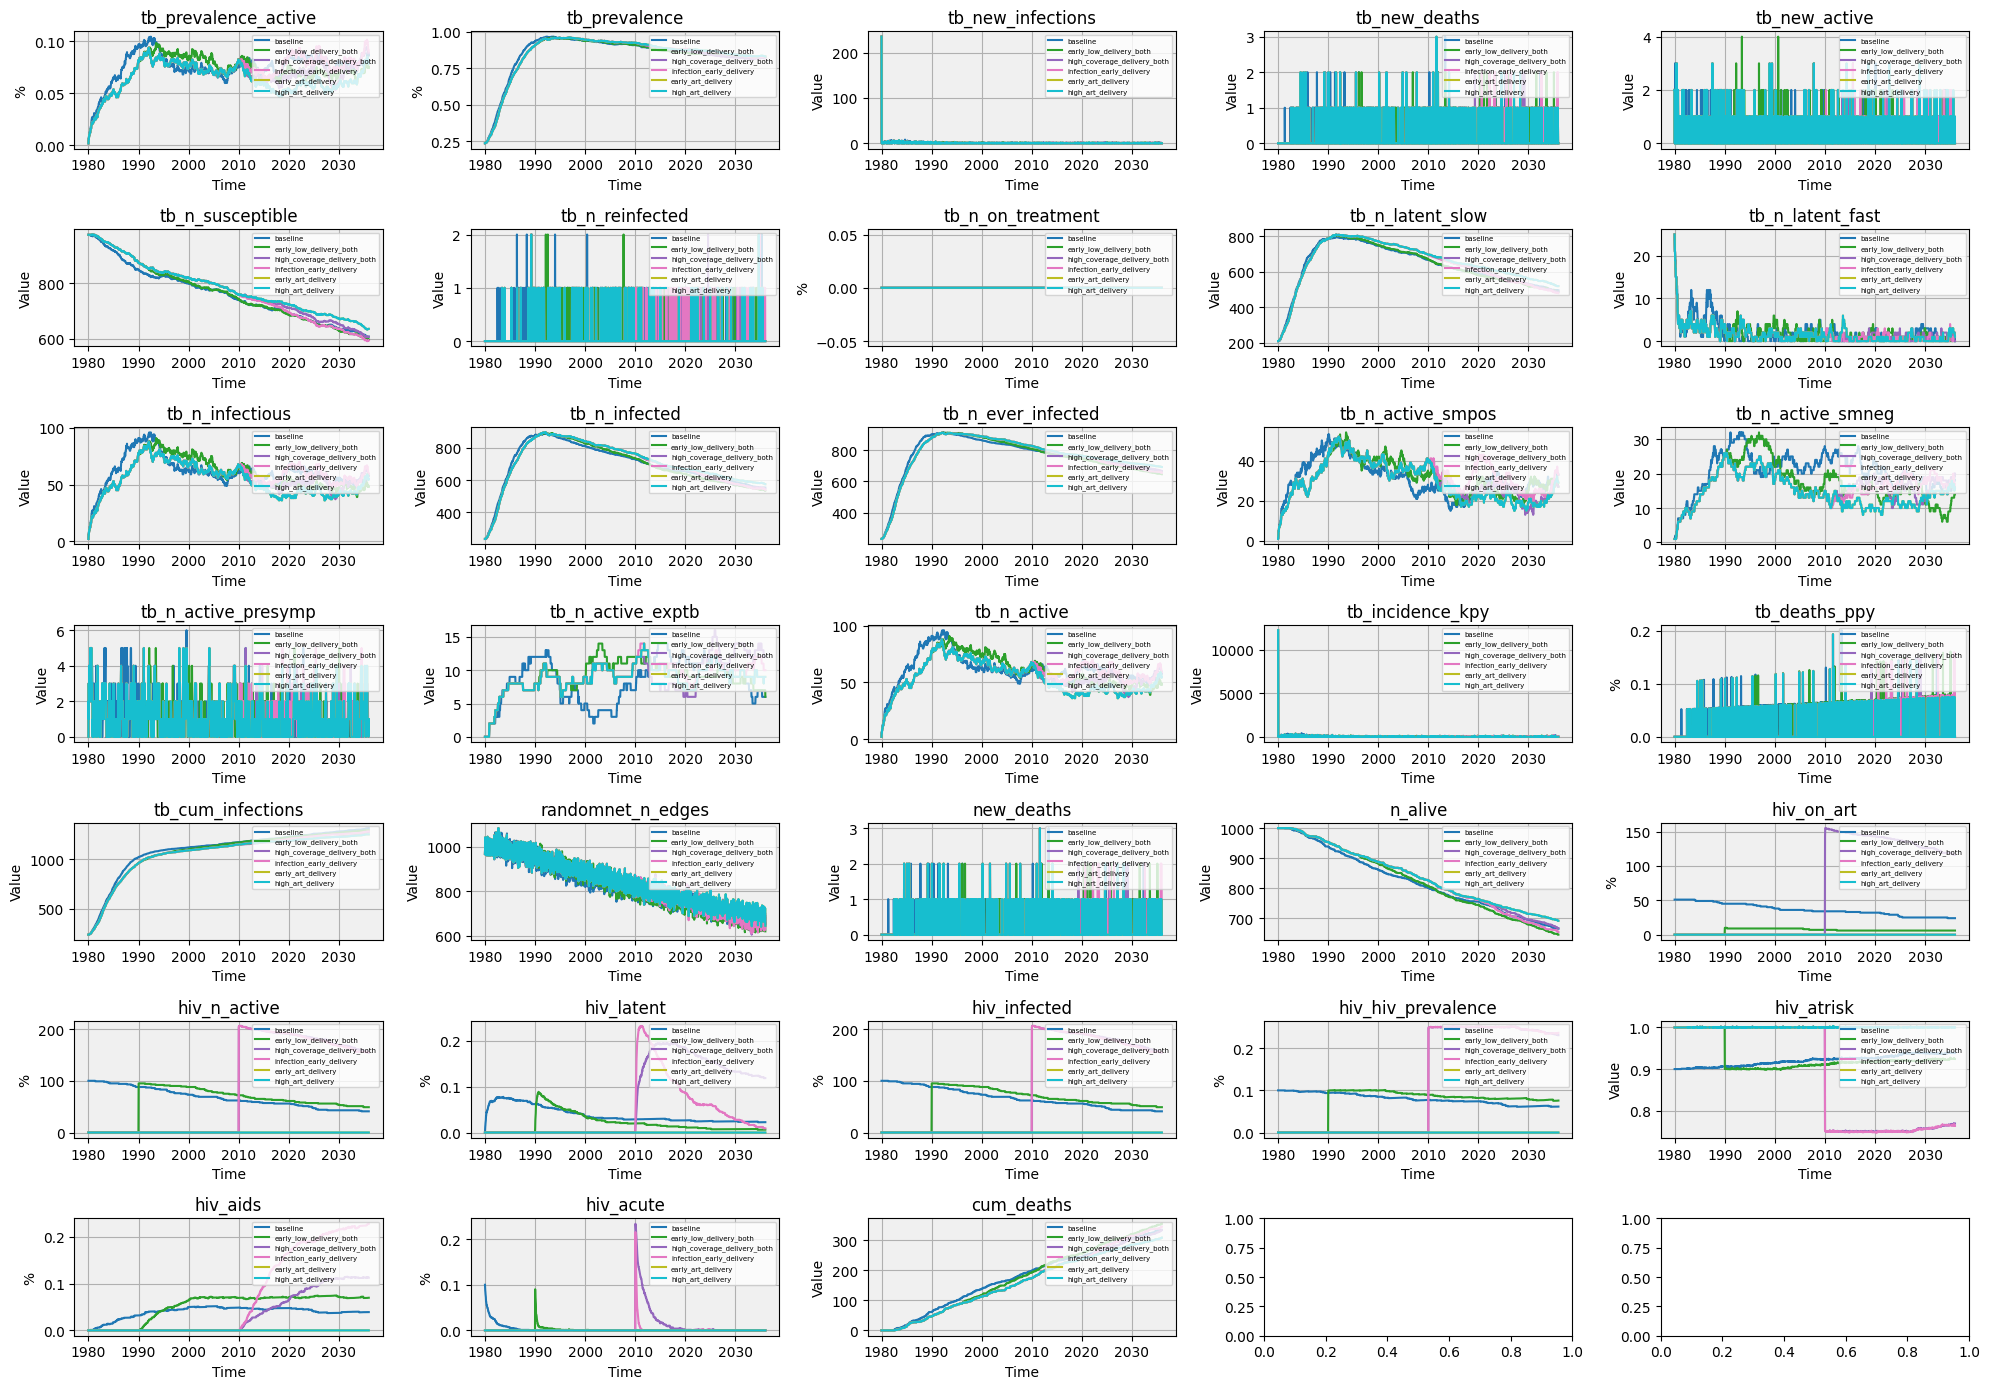

In [10]:
# Run everything
flat_results = run_scenarios()
plot_results(flat_results)